<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 使用大型语言模型进行令牌分类 #
>Token Classification with Large Language Models

## 01 - 使用预训练模型进行命名实体识别 ##
>Named Entity Recognition with Pre-Trained Model

在本笔记本中，您将学习如何使用预训练的令牌分类模型。具体来说，我们将使用命名实体识别模型。NER，也称为实体分块、识别或提取，是检测和分类文本中关键信息（实体）的任务。换句话说，NER 模型将一段文本作为输入，并针对文本中的每个单词，模型识别该单词所属的类别。例如，在一个句子中：`Mary lives in Santa Clara and works at NVIDIA`，模型应该检测到 `Mary` 是一个人，`Santa Clara` 是一个位置，`NVIDIA` 是一家公司。


**目录** <br>
本笔记本涵盖以下部分：
* 项目概述
* 数据集
    * 下载和预处理数据(Preprocess data)
    * 数据标注(Labeling Data)（可选）
* 使用预训练模型(Pre-Trained Model)
    * 下载模型
    * 进行预测
    * 模型评估
* 微调(Fine-Tune)预训练模型


## 项目概述 ##
>Project Overview

<img src='images/workflow.png' width=1080>

## 数据集 ##
>Dataset

对于本笔记本，我们将使用 [GMB（Groningen Meaning Bank, 格罗宁根语义库）](http://www.let.rug.nl/bjerva/gmb/about.php) 语料库进行命名实体识别。GMB 是一个相当大的语料库，包含大量注释。数据使用 [IOB 格式](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))（“内部”、“外部”、“开始”的缩写）进行标记，这意味着每个注释还需要 **I**、**O** 或 **B** 前缀。

数据集中出现了以下类别：
* **LOC** - 地理实体
* **ORG** - 组织
* **PER** - 人物
* **GPE** - 地理政治实体
* **TIME** - 时间指示符
* **ART** - 人工制品
* **EVE** - 事件
* **NAT** - 自然现象


_注意_：GMB 并非完全由人工标注(human annotated)，并且不被认为是 100% 正确的。在本练习中，由于这些类别的示例数量较少，因此将 **ART**、**EVE** 和 **NAT** 类合并为 **MISC** 类。

The following classes appear in the dataset:
* **LOC** - Geographical Entity
* **ORG** - Organization
* **PER** - Person
* **GPE** - Geopolitical Entity
* **TIME** - Time indicator
* **ART** - Artifact
* **EVE** - Event
* **NAT** - Natural Phenomenon

对于令牌分类任务，NeMo 要求数据采用特定的格式。数据需要分成以下文件：
* `text.txt` 和 
* `labels.txt`

**text.txt** 文件的每一行包含文本序列，其中单词用空格分隔，例如：`[单词] [空格] [单词] [空格] [单词]`。**labels.txt** 文件包含 **text.txt** 中每个单词对应的标签，标签用空格分隔，例如：`[标签] [空格] [标签] [空格] [标签]`。


例如：
* **text.txt**
```
Jennifer is from New York City .
She likes ...
...
```
* **labels.txt**
```
B-PER O O B-LOC I-LOC I-LOC O
O O ...
...
```


### 下载和预处理数据 ###
>Download and Preprocess Data

In [1]:
# !pip install wget  # 安装 wget 库，用于下载文件
import os  # 导入操作系统的库
import wget  # 导入 wget 库，用于下载文件

# 设置数据路径
DATA_DIR="data/GMB"  # 定义数据文件夹的路径


In [2]:
# 检查数据文件夹是否包含 4 个文件
!ls -l $DATA_DIR  # 使用 shell 命令 ls 列出数据文件夹的内容，并显示详细信息，例如文件大小和权限


total 11140
-rw-r--r-- 1 root root      77 Sep 26 05:49 label_ids.csv
-rw-r--r-- 1 root root  407442 Sep 26 05:49 labels_dev.txt
-rw-r--r-- 1 root root 3169783 Sep 26 05:49 labels_train.txt
-rw-r--r-- 1 root root  891020 Sep 26 05:49 text_dev.txt
-rw-r--r-- 1 root root 6928251 Sep 26 05:49 text_train.txt


In [3]:
# 预览数据
print('文本:')  # 打印提示信息，指示即将显示文本数据
!head -n 5 {DATA_DIR}/text_train.txt  # 使用 shell 命令 head 打印 text_train.txt 文件的前 5 行

print('标签:')  # 打印提示信息，指示即将显示标签数据
!head -n 5 {DATA_DIR}/labels_train.txt  # 使用 shell 命令 head 打印 labels_train.txt 文件的前 5 行


文本:
New Zealand 's cricket team has scored a morale-boosting win over Bangladesh in the first of three one-day internationals in New Zealand .
Despite Bangladesh 's highest total ever in a limited-overs match , the Kiwis were able to win the match by six wickets in Auckland .
Opening batsman Jamie How led all scorers with 88 runs as New Zealand reached 203-4 in 42.1 overs .
The score was in response to Bangladesh 's total of 201 all out in 46.3 overs .
Mohammad Ashraful led the visitors with 70 runs , including 10 fours and one six on the short boundaries of the Eden Park ground .
标签:
B-LOC I-LOC O O O O O O O O O B-LOC O O B-TIME I-TIME I-TIME I-TIME O O B-LOC I-LOC O
O B-LOC O O O O O O O O O O B-GPE O O O O O O O O O O B-LOC O
O O B-PER I-PER O O O O O O O B-LOC I-LOC O O O O O O
O O O O O O B-LOC O O O O O O O O O O
B-PER I-PER O O O O O O O O O O O O O O O O O O O B-LOC I-LOC O O


### 数据标注 ###
>Labeling Data

如果您有原始数据，NeMo 建议使用 [Datasaur](https://datasaur.ai/) 标注平台来为数据应用标签。Datasaur 专为标注文本数据而设计，支持基本的 NLP 标注任务，例如命名实体识别和文本分类，以及高级 NLP 任务，例如依存句法分析和共指消解。您可以在 https://datasaur.ai/sign-up/ 免费注册 Datasaur。上传文件后，您可以从多种 NLP 项目类型中进行选择，并使用 Datasaur 界面对数据进行标注。标注后，您可以使用 conll_2003 格式导出标注数据，该格式可直接与 NeMo 集成。您可以在 [此处](https://www.youtube.com/watch?v=I9WVmnnSciE) 找到视频演练。


## 使用预训练模型 ##
>Use Pre-Trained Model

NeMo 支持 NER 和其他令牌级分类任务。这些模型通常包含一个预训练的 [BERT](https://arxiv.org/pdf/1810.04805.pdf) 模型，后面跟着一个令牌分类层。我们首先使用一个预训练的模型。`TokenClassificationModel` 继承自 `NLPModel`，并具有以下方法：
* `TokenClassificationModel.add_predictions()`
* `TokenClassificationModel.evaluate_from_file()`

这些方法在进行推理和评估模型性能时非常有用。`TokenClassificationModel` 的其他功能可以在 [源代码](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/nlp/models/token_classification/token_classification_model.py) 中找到。

### 下载预训练模型 ###
>Download Pre-Trained Model

In [4]:
# !pip install git+https://github.com/NVIDIA/NeMo.git  # 安装 NeMo 库，用于自然语言处理任务
# !pip install hydra-core  # 安装 Hydra 库，用于配置管理
# !pip install pytorch_lightning  # 安装 PyTorch Lightning 库，用于深度学习模型训练和评估
# !pip install einops  # 安装 Einops 库，用于张量操作
# !pip install transformers  # 安装 Transformers 库，用于预训练语言模型
# !pip install sentencepiece  # 安装 SentencePiece 库，用于分词
# !pip install braceexpand  # 安装 BraceExpand 库，用于文件路径扩展
# !pip install webdataset  # 安装 WebDataset 库，用于数据加载
# !pip install h5py  # 安装 h5py 库，用于操作 HDF5 文件
# !pip install ijson  # 安装 IJSON 库，用于解析 JSON 文件
# !pip install pandas  # 安装 Pandas 库，用于数据分析和处理
# !pip install sacremoses  # 安装 Sacremoses 库，用于自然语言处理任务
# !pip install matplotlib  # 安装 Matplotlib 库，用于绘图
# !pip install megatron  # 安装 Megatron 库，用于大规模语言模型训练
# !pip install megatron.core  # 安装 Megatron.core 库，用于大规模语言模型训练
# !pip install sacrebleu  # 安装 SacreBLEU 库，用于机器翻译评估
# !pip install rouge_score  # 安装 Rouge-Score 库，用于文本摘要评估
!pip install apex # 安装 apex 库，用于混合精度训练
from nemo.collections.nlp.models import TokenClassificationModel  # 导入 TokenClassificationModel 类，用于命名实体识别任务

# 列出可用的预训练模型
for model in TokenClassificationModel.list_available_models():  # 遍历 TokenClassificationModel 类中定义的可用预训练模型
    print(model)  # 打印每个模型的名称


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
NOTE! Installing ujson may make loading annotations faster.
PretrainedModelInfo(
	pretrained_model_name=ner_en_bert,
	description=The model was trained on GMB (Groningen Meaning Bank) corpus for entity recognition and achieves 74.61 F1 Macro score.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ner_en_bert/versions/1.10/files/ner_en_bert.nemo
)


_注意_：这些模型是针对令牌分类训练的。要获取所有受支持模型的列表，请使用 `nemo.collections.nlp.modules.get_pretrained_lm_models_list(include_external=True)`。预训练模型列表预计会随着模型可用性的变化而变化。

In [5]:
# 下载并加载预训练的基于 BERT 的命名实体识别模型
pretrained_ner_model=TokenClassificationModel.from_pretrained("ner_en_bert")  # 使用 from_pretrained 方法从 Hugging Face 模型库中下载并加载名为 "ner_en_bert" 的预训练模型


[NeMo I 2024-09-26 07:10:50 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ner_en_bert/versions/1.10/files/ner_en_bert.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo
[NeMo I 2024-09-26 07:10:54 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2024-09-26 07:10:57 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: /tmp/tmpay_g3g_a/tokenizer.vocab_file, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2024-09-26 07:10:57 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.
[NeMo W 2024-09-26 07:10:57 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
    
[NeMo W 2024-09-26 07:10:57 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 64
    

[NeMo W 2024-09-26 07:11:00 modelPT:244] You tried to register an artifact under config key=language_model.config_file but an artifact for it has already been registered.


[NeMo I 2024-09-26 07:11:01 save_restore_connector:249] Model TokenClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo.


### 进行预测 ###
>Make Predictions

In [6]:
# 定义用于推理的查询列表
queries=[
    'we bought four shirts from the nvidia gear store in santa clara.',  # 第一个查询语句
    'Nvidia is a company.',  # 第二个查询语句
]

# 进行样本预测
results=pretrained_ner_model.add_predictions(queries)  # 使用预训练模型对每个查询执行预测

# 显示预测结果
for query, result in zip(queries, results):  # 遍历每个查询和对应的预测结果
    print(f'查询 : {query}')  # 打印查询语句
    print(f'结果: {result.strip()}\n')  # 打印预测结果，并去除结果字符串中的空格
    print()  # 打印空行，以便区分每个查询的结果


[NeMo I 2024-09-26 07:11:34 token_classification_dataset:123] Setting Max Seq length to: 17
[NeMo I 2024-09-26 07:11:34 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-09-26 07:11:34 data_preprocessing:406] Min: 9 |                  Max: 17 |                  Mean: 13.0 |                  Median: 13.0
[NeMo I 2024-09-26 07:11:34 data_preprocessing:412] 75 percentile: 15.00
[NeMo I 2024-09-26 07:11:34 data_preprocessing:413] 99 percentile: 16.92


[NeMo W 2024-09-26 07:11:34 token_classification_dataset:152] 0 are longer than 17


[NeMo I 2024-09-26 07:11:34 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 07:11:34 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 07:11:34 token_classification_dataset:157] subtokens: [CLS] we bought four shirts from the n ##vid ##ia gear store in santa clara . [SEP]
[NeMo I 2024-09-26 07:11:34 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[NeMo I 2024-09-26 07:11:34 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[NeMo I 2024-09-26 07:11:34 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0
查询 : we bought four shirts from the nvidia gear store in santa clara.
结果: we bought four shirts from the nvidia[B-ORG] gear store in santa[B-LOC] clara[I-LOC].


查询 : Nvidia is a company.
结果: Nvidia[B-ORG] is a company.




### 评估预测结果 ###
>Evaluate Predictions ###

要查看模型的性能，我们可以生成类似于之前所做方式的预测，并将其与标签进行比较。或者，`evaluate_from_file()` 方法使我们能够根据 `text_file` 和 `labels_file` 评估模型。可以选择使用 `add_confusion_matrix` 来获取模型性能的可视化表示。

In [7]:
# 创建开发数据的一个子集
!head -n 100 $DATA_DIR/text_dev.txt > $DATA_DIR/sample_text_dev.txt  # 使用 shell 命令 head 取出 text_dev.txt 文件的前 100 行，并保存到 sample_text_dev.txt 文件
!head -n 100 $DATA_DIR/labels_dev.txt > $DATA_DIR/sample_labels_dev.txt  # 使用 shell 命令 head 取出 labels_dev.txt 文件的前 100 行，并保存到 sample_labels_dev.txt 文件


现在，让我们为提供的文本文件生成预测。如果也指定了标签文件，则模型将评估预测结果并绘制混淆矩阵。

[NeMo I 2024-09-26 07:12:50 token_classification_dataset:123] Setting Max Seq length to: 70
[NeMo I 2024-09-26 07:12:50 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-09-26 07:12:50 data_preprocessing:406] Min: 11 |                  Max: 70 |                  Mean: 26.9 |                  Median: 26.0
[NeMo I 2024-09-26 07:12:50 data_preprocessing:412] 75 percentile: 33.00
[NeMo I 2024-09-26 07:12:50 data_preprocessing:413] 99 percentile: 65.05


[NeMo W 2024-09-26 07:12:50 token_classification_dataset:152] 0 are longer than 70


[NeMo I 2024-09-26 07:12:50 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 07:12:50 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 07:12:50 token_classification_dataset:157] subtokens: [CLS] hamas refuses to recognize israel , and has vowed to undermine palestinian leader mahmoud abbas ' s efforts to make peace with the jewish state . [SEP]
[NeMo I 2024-09-26 07:12:50 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:12:50 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:12:50 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

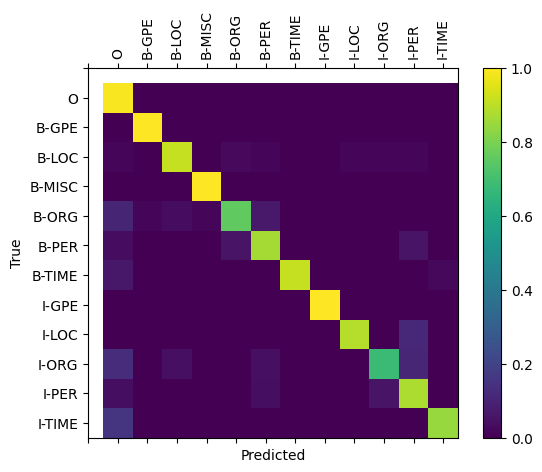

In [8]:
WORK_DIR = "WORK_DIR"  # 定义工作目录的路径

# 评估模型在样本数据上的性能
pretrained_ner_model.evaluate_from_file(  # 使用 evaluate_from_file 方法评估模型性能
    text_file=os.path.join(DATA_DIR, 'sample_text_dev.txt'),  # 指定评估使用的文本文件路径
    labels_file=os.path.join(DATA_DIR, 'sample_labels_dev.txt'),  # 指定评估使用的标签文件路径
    output_dir=WORK_DIR,  # 指定评估结果保存的目录
    add_confusion_matrix=True,  # 指定是否计算混淆矩阵
    normalize_confusion_matrix=True,  # 指定是否对混淆矩阵进行归一化处理
    batch_size=1  # 指定评估使用的批次大小
)


## 微调预训练模型 ##
>Fine-Tune a Pre-Trained Model

如果不指定配置文件，NeMo 将使用模型和训练器的默认配置。当微调预训练的 NER 模型时，我们需要在训练前设置训练和评估数据，如果文件名是 `labels_dev.txt`、`labels_train.txt`、`text_dev.txt` 和 `text_train.txt`，则数据集目录是唯一必需的参数。

In [9]:
import pytorch_lightning as pl  # 导入 PyTorch Lightning 库，用于深度学习模型训练和评估

# 设置数据目录以获取类别权重统计信息
pretrained_ner_model.update_data_dir(DATA_DIR)  # 更新模型的数据目录，以便读取训练数据并计算类别权重

# 设置训练和验证 PyTorch 数据加载器
pretrained_ner_model.setup_training_data()  # 设置训练数据加载器
pretrained_ner_model.setup_validation_data()  # 设置验证数据加载器


[NeMo I 2024-09-26 07:13:29 token_classification_model:84] Setting model.dataset.data_dir to data/GMB.
[NeMo I 2024-09-26 07:13:29 token_classification_utils:118] Processing data/GMB/labels_train.txt
[NeMo I 2024-09-26 07:13:29 token_classification_utils:138] Using provided labels mapping {'O': 0, 'B-GPE': 1, 'B-LOC': 2, 'B-MISC': 3, 'B-ORG': 4, 'B-PER': 5, 'B-TIME': 6, 'I-GPE': 7, 'I-LOC': 8, 'I-MISC': 9, 'I-ORG': 10, 'I-PER': 11, 'I-TIME': 12}
[NeMo I 2024-09-26 07:13:29 token_classification_utils:154] Labels mapping {'O': 0, 'B-GPE': 1, 'B-LOC': 2, 'B-MISC': 3, 'B-ORG': 4, 'B-PER': 5, 'B-TIME': 6, 'I-GPE': 7, 'I-LOC': 8, 'I-MISC': 9, 'I-ORG': 10, 'I-PER': 11, 'I-TIME': 12} saved to : data/GMB/label_ids.csv
[NeMo I 2024-09-26 07:13:44 token_classification_utils:163] Three most popular labels in data/GMB/labels_train.txt:
[NeMo I 2024-09-26 07:13:44 data_preprocessing:194] label: 0, 1014899 out of 1199472 (84.61%).
[NeMo I 2024-09-26 07:13:44 data_preprocessing:194] label: 2, 43529 ou

[NeMo W 2024-09-26 07:15:18 token_classification_dataset:152] 1 are longer than 128


[NeMo I 2024-09-26 07:15:18 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 07:15:18 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 07:15:18 token_classification_dataset:157] subtokens: [CLS] new zealand ' s cricket team has scored a morale - boost ##ing win over bangladesh in the first of three one - day internationals in new zealand . [SEP]
[NeMo I 2024-09-26 07:15:18 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:15:18 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[NeMo W 2024-09-26 07:15:32 token_classification_dataset:152] 0 are longer than 79


[NeMo I 2024-09-26 07:15:32 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 07:15:32 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 07:15:32 token_classification_dataset:157] subtokens: [CLS] hamas refuses to recognize israel , and has vowed to undermine palestinian leader mahmoud abbas ' s efforts to make peace with the jewish state . [SEP]
[NeMo I 2024-09-26 07:15:32 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:15:32 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:15:32 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [10]:
# 设置损失函数
pretrained_ner_model.setup_loss()  # 设置模型使用的损失函数


CrossEntropyLoss()

_Note:_ Use `class_balancing='weighted_loss'` if you want to add class weights to the `CrossEntropyLoss`. 

In [11]:
# 创建一个 PyTorch Lightning 训练器，并再次调用 `fit` 方法
fast_dev_run= True  # 设置是否进行快速开发运行，用于快速测试模型
trainer=pl.Trainer(devices=1, accelerator='gpu', fast_dev_run=fast_dev_run)  # 创建一个训练器，指定使用 1 个 GPU 进行训练，并设置快速开发运行
trainer.fit(pretrained_ner_model)  # 使用训练器对模型进行训练


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-09-26 07:16:08 modelPT:721] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 5e-05
        maximize: False
        weight_decay: 0.0
    )
[NeMo I 2024-09-26 07:16:08 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7f3083efbf40>" 
    will be used during training (effective maximum steps = 1) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 1
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | BertEncoder          | 109 M 
1 | classifier            | TokenClassifier      | 600 K 
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     
---------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
440.331   Total estimated model params size (MB)
[NeMo W 2024-09-26 07:16:08 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NeMo I 2024-09-26 07:16:08 token_classification_model:159] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.13      98.71      98.92       1161
    B-GPE (label_id: 1)                                     90.91     100.00      95.24         20
    B-LOC (label_id: 2)                                     85.71      95.45      90.32         44
    B-MISC (label_id: 3)                                   100.00     100.00     100.00          2
    B-ORG (label_id: 4)                                     80.95      77.27      79.07         44
    B-PER (label_id: 5)                                     83.33      88.89      86.02         45
    B-TIME (label_id: 6)                                    81.48      95.65      88.00         23
    I-GPE (label_id: 7)                                    100.00     100.00     100.00          4
    I-LOC (label_id: 8)                 

`Trainer.fit` stopped: `max_steps=1` reached.


_注意_：在训练模型时，我们可以使用配置文件来设置模型（和训练器trainer）。由于我们执行的任务与预训练模型相同，因此不需要这样做。我们将在下一个笔记本中训练一个自定义令牌分类模型，这将需要使用配置文件。此外，为了演示，我们将 `fast_dev_run` 设置为 `True`，这样训练器将运行 1 个训练批次和 1 个验证批次。对于实际的模型训练，请禁用此标志。

[NeMo I 2024-09-26 07:16:18 token_classification_dataset:123] Setting Max Seq length to: 70
[NeMo I 2024-09-26 07:16:18 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-09-26 07:16:18 data_preprocessing:406] Min: 11 |                  Max: 70 |                  Mean: 26.9 |                  Median: 26.0
[NeMo I 2024-09-26 07:16:18 data_preprocessing:412] 75 percentile: 33.00
[NeMo I 2024-09-26 07:16:18 data_preprocessing:413] 99 percentile: 65.05


[NeMo W 2024-09-26 07:16:18 token_classification_dataset:152] 0 are longer than 70


[NeMo I 2024-09-26 07:16:18 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 07:16:18 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 07:16:18 token_classification_dataset:157] subtokens: [CLS] hamas refuses to recognize israel , and has vowed to undermine palestinian leader mahmoud abbas ' s efforts to make peace with the jewish state . [SEP]
[NeMo I 2024-09-26 07:16:18 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:16:18 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 07:16:18 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

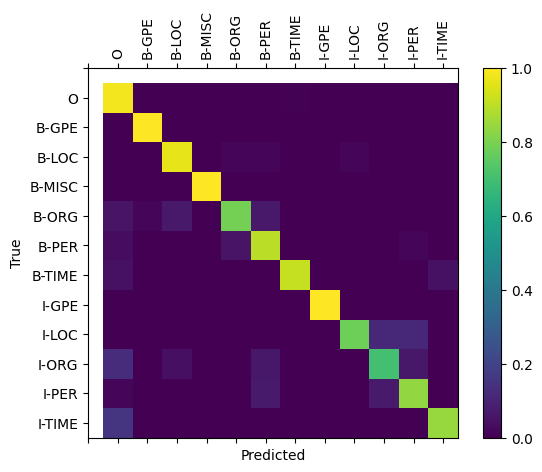

In [12]:
# 评估模型在样本数据上的性能
pretrained_ner_model.evaluate_from_file(  # 使用 evaluate_from_file 方法评估模型性能
    text_file=os.path.join(DATA_DIR, 'sample_text_dev.txt'),  # 指定评估使用的文本文件路径
    labels_file=os.path.join(DATA_DIR, 'sample_labels_dev.txt'),  # 指定评估使用的标签文件路径
    output_dir=WORK_DIR,  # 指定评估结果保存的目录
    add_confusion_matrix=True,  # 指定是否计算混淆矩阵
    normalize_confusion_matrix=True,  # 指定是否对混淆矩阵进行归一化处理
    batch_size=1  # 指定评估使用的批次大小
)


In [13]:
# 重启内核
import IPython  # 导入 IPython 库

app = IPython.Application.instance()  # 获取 IPython 应用实例
app.kernel.do_shutdown(True)  # 使用 do_shutdown 方法关闭当前内核，并将参数设置为 True 以强制关闭内核


{'status': 'ok', 'restart': True}

**做得好！** 准备好后，让我们转到 [下一个笔记本](./02_domain-specific_token_classification_model.ipynb)。

<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>